In [8]:
from seirsplus.models import *
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import json
import  pickle
from shapely.geometry import Polygon, Point, MultiPoint
from scipy.spatial import ConvexHull
from dateutil import parser

from multiprocessing import Pool, freeze_support

%matplotlib inline

In [1]:
# Below section for creating graphs and monte carlo simul

def get_three_tuple(df):
    arr = []
    for row in df.iterrows():
        v1 = np.percentile(row[1], 2.5)
        v2 = np.percentile(row[1], 50)
        v3 = np.percentile(row[1], 97.5)
        arr.append(np.array([v1,v2,v3]))
    return np.array(arr)

def single_run(model_init, model_run, i):
    model = SEIRSNetworkModel(**model_init)
    model.run(**model_run)
    time=pd.to_datetime(pd.Series(model.tseries),unit='d',origin='2020-04-01')   
    
    df_tempI=pd.DataFrame({'t':time, i:model.numI})
    df_tempI.set_index('t',inplace=True)
    df_tempI['t']=df_tempI.index.date
    df_tempI.reset_index(drop=True,inplace=True)
    df_tempI.set_index('t',inplace=True)
    df_tempI.reset_index(inplace=True)
    df_tempI = pd.pivot_table(df_tempI, index='t', aggfunc='mean')

    df_tempDI=pd.DataFrame({'t':time, i:model.numD_I})
    df_tempDI.set_index('t',inplace=True)
    df_tempDI['t']=df_tempDI.index.date
    df_tempDI.reset_index(drop=True,inplace=True)
    df_tempDI.set_index('t',inplace=True)
    df_tempDI.reset_index(inplace=True)
    df_tempDI= pd.pivot_table(df_tempDI, index='t', aggfunc='mean')

    df_tempR=pd.DataFrame({'t':time, i:model.numR})
    df_tempR.set_index('t',inplace=True)
    df_tempR['t']=df_tempR.index.date
    df_tempR.reset_index(drop=True,inplace=True)
    df_tempR.set_index('t',inplace=True)
    df_tempR.reset_index(inplace=True)
    df_tempR= pd.pivot_table(df_tempR, index='t', aggfunc='mean')

    df_tempF=pd.DataFrame({'t':time, i:model.numF})
    df_tempF.set_index('t',inplace=True)
    df_tempF['t']=df_tempF.index.date
    df_tempF.reset_index(drop=True,inplace=True)
    df_tempF.set_index('t',inplace=True)
    df_tempF.reset_index(inplace=True)
    df_tempF= pd.pivot_table(df_tempF, index='t', aggfunc='mean')

    return df_tempI, df_tempDI, df_tempR, df_tempF


def monte(N, initI,theta_E, theta_I ,mf, checkpoints, G, sim=2):
    beta = 0.182
    sigma = 1.0/5.2
    gamma = 1.0/15
    mu_I = 0.004
    p = 0.6
    Q = None
    beta_D = 0.155
    sigma_D = 1.0/5.2
    mu_D = 0.0004
    theta_E = theta_E
    theta_I = theta_I
    phi_E = 0.4
    phi_I = 0.8
    initN = N
    initI = initI
    initE = initI*4
    initD_E = 0.0
    initD_I = 0
    initR = 0
    initF = 0
    x_i = 0.001
    psi_E = 0.04
    psi_I = 1
    q = 0.3
    gamma_D = gamma

    # Creating dataframe
    time_index=pd.date_range(start='2020-04-01', periods=90)
    df_I=pd.DataFrame(index=time_index)
    df_DI=pd.DataFrame(index=time_index)
    df_R = pd.DataFrame(index=time_index)
    df_F = pd.DataFrame(index=time_index)
    
    model_init = {'G' : G, 'Q' : G_Quarantine, 'beta' : beta, 'sigma' : sigma,
                 'gamma' : gamma, 'mu_I' : mu_I, 'beta_D' : beta_D, 'sigma_D' : sigma_D,
                 'gamma_D' : gamma_D, 'mu_D' : mu_D, 'theta_E' : theta_E, 'theta_I' : theta_I,
                 'phi_E' : phi_E, 'phi_I' : phi_I, 'psi_E' : psi_E, 'psi_I' : psi_I, 'q' : 0.3,
                 'initI' : initI, 'initE' : initE, 'initD_E' : initD_E, 'initD_I' : initD_I}
    
    model_run = {'T':120, 'checkpoints':checkpoints, 'verbose':False}
    
    pool = Pool(processes = 32)
    
    results = []
    for i in range(1, sim+1):
        results.append(pool.apply_async(single_run, args=(model_init, model_run, i)))
    
    pool.close()
    pool.join()

    for res in results:
        df_l = res.get()
        df_I=df_I.merge(df_l[0], how='outer', right_index=True, left_index=True).ffill(axis=0).fillna(np.NaN)        

        df_DI=df_DI.merge(df_l[1], how='outer', right_index=True, left_index=True).ffill(axis=0).fillna(np.NaN)        

        df_R=df_R.merge(df_l[2], how='outer', right_index=True, left_index=True).ffill(axis=0).fillna(np.NaN)

        df_F=df_F.merge(df_l[3], how='outer', right_index=True, left_index=True).ffill(axis=0).fillna(np.NaN)
        
        df_I =df_I.interpolate(method='linear', limit_direction='forward', axis=0)
        df_DI =df_DI.interpolate(method='linear', limit_direction='forward', axis=0)
        df_R = df_R.interpolate(method='linear',limit_direction='forward',axis = 0)
        df_F = df_F.interpolate(method='linear',limit_direction='forward',axis = 0)

    df_I = df_I*100.0/N
    df_DI = df_DI*100.0/N
    df_R = df_R*100.0/N
    df_F = df_F*100.0/N
    
    return df_I, df_DI, df_R, df_F

#     # Changes for looking at actual numbers
#     df_Iavg=pd.DataFrame.mean(df_I, axis=1)*100.0/N
#     df_DIavg=pd.DataFrame.mean(df_DI, axis=1)*100.0/N
#     df_Ravg = pd.DataFrame.mean(df_R, axis = 1)*100.0/N
#     df_Favg = pd.DataFrame.mean(df_F, axis = 1)*100.0/N
        
#     df_Icstd=pd.DataFrame.std(df_I.cumsum(axis=0), axis=1)*100.0/N
#     df_DIcstd=pd.DataFrame.std(df_DI.cumsum(axis=0), axis=1)*100.0/N
#     df_Rcstd=pd.DataFrame.std(df_R.cumsum(axis=0), axis=1)*100.0/N
#     df_Fcstd=pd.DataFrame.std(df_F.cumsum(axis=0), axis=1)*100.0/N

#     df_Istd=pd.DataFrame.std(df_I, axis=1)*100.0/N
#     df_DIstd=pd.DataFrame.std(df_DI, axis=1)*100.0/N
#     df_Rstd=pd.DataFrame.std(df_R, axis=1)*100.0/N
#     df_Fstd=pd.DataFrame.std(df_F, axis=1)*100.0/N

#     return {
#         'df_DI':df_DIavg, 'df_I': df_Iavg,'df_R': df_Ravg, 'df_F':df_Favg,
#         'df_Icstd':df_Icstd, 'df_Rcstd':df_Rcstd, 'df_Fcstd': df_Fcstd, 'df_DIcstd':df_DIcstd,
#         'df_Istd':df_Istd, 'df_Rstd':df_Rstd, 'df_Fstd': df_Fstd, 'df_DIstd':df_DIstd,
#            }

In [10]:
def gen_graphs(numNodes, coeff):
    G_normal = nx.erdos_renyi_graph(n=numNodes, p = coeff*1.1/numNodes, seed=42, directed=False)
    G_relaxed = nx.erdos_renyi_graph(n=numNodes, p = coeff*0.301/numNodes , seed=42, directed=False)
    G_Quarantine = nx.erdos_renyi_graph(n=numNodes, p = coeff*0.006/numNodes , seed=42, directed=False)
    
    return G_normal, G_relaxed, G_Quarantine

In [11]:
freeze_support()
plt.rcParams['figure.figsize'] = (15, 8)

In [12]:
with open('region_sim1.p','rb') as fp:
    S5,S10,S20 = pickle.load(fp)

In [13]:
date_length = len(S10['timeseries'][15:])
S5_ts = np.array([float(j[1])*100.0/S5['total_pop'] for j in S5['timeseries'][15:]])-np.array([float(j[1])*100.0/S5['total_pop'] for j in S5['timeseries'][14:-1]])
S10_ts = np.array([float(j[1])*100.0/S10['total_pop'] for j in S10['timeseries'][15:]])-np.array([float(j[1])*100.0/S10['total_pop'] for j in S10['timeseries'][14:-1]])
S20_ts = np.array([float(j[1])*100.0/S20['total_pop'] for j in S20['timeseries'][15:]])-np.array([float(j[1])*100.0/S20['total_pop'] for j in S20['timeseries'][14:-1]])

I = 14
Et = [0.000, 0.00001,0.00016,0.0002]
It = [0.00007, 0.00075, 0.0009, 0.004]
sim = 1000

In [14]:
# With current testing and social distancing throughout
numNodes = S5['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, np.log(S5['total_pop']))

final = []
initI = I
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

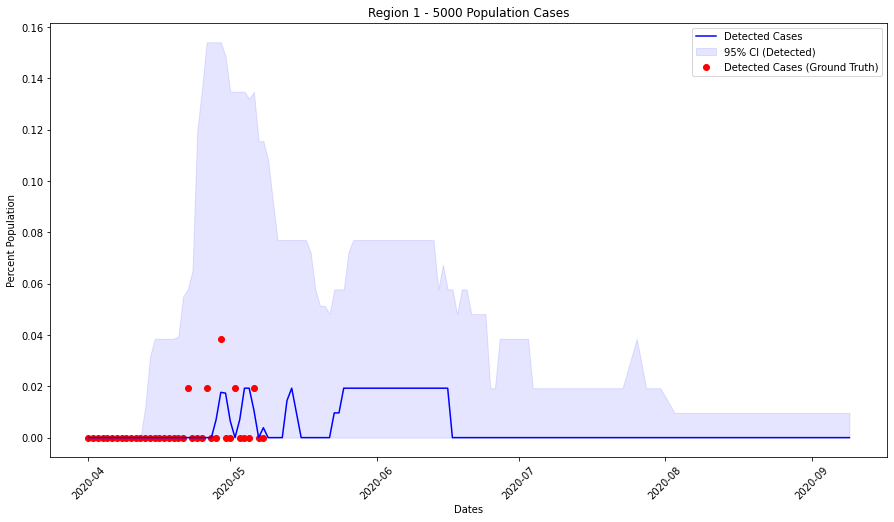

In [15]:
title = 'Region 1 - 5000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S5_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')

In [16]:
coeff = (S10['total_pop']*np.log(S10['total_pop'])*S5['area']*S5['F(S)']**2)/(S5['total_pop']*np.log(S5['total_pop'])*S10['area']*S10['F(S)']**2)

In [17]:
# With current testing and social distancing throughout
numNodes = S10['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, coeff*np.log(S5['total_pop']))

final = []
initI = int(I*coeff)
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

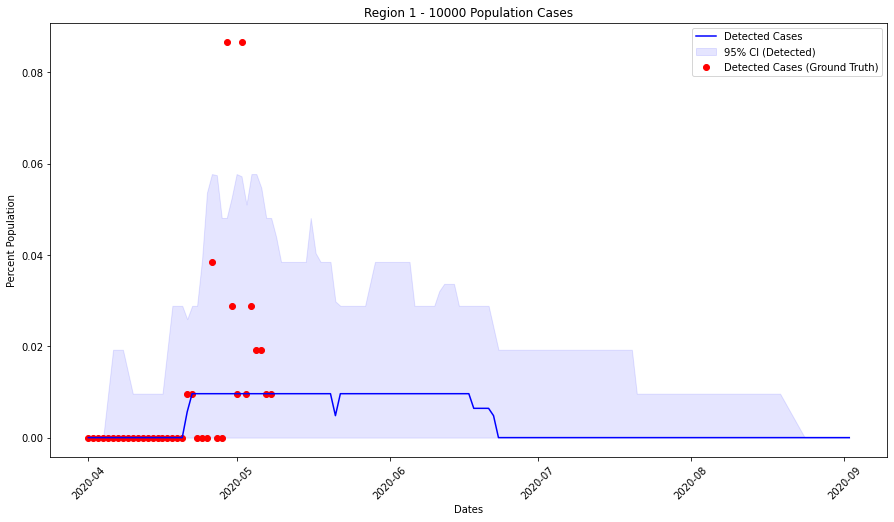

In [18]:
title = 'Region 1 - 10000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S10_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')

In [19]:
coeff = (S20['total_pop']*np.log(S20['total_pop'])*S5['area']*S5['F(S)']**2)/(S5['total_pop']*np.log(S5['total_pop'])*S20['area']*S20['F(S)']**2)

In [20]:
# With current testing and social distancing throughout
numNodes = S20['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, coeff*np.log(S5['total_pop']))


final = []
initI = int(I*coeff)
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

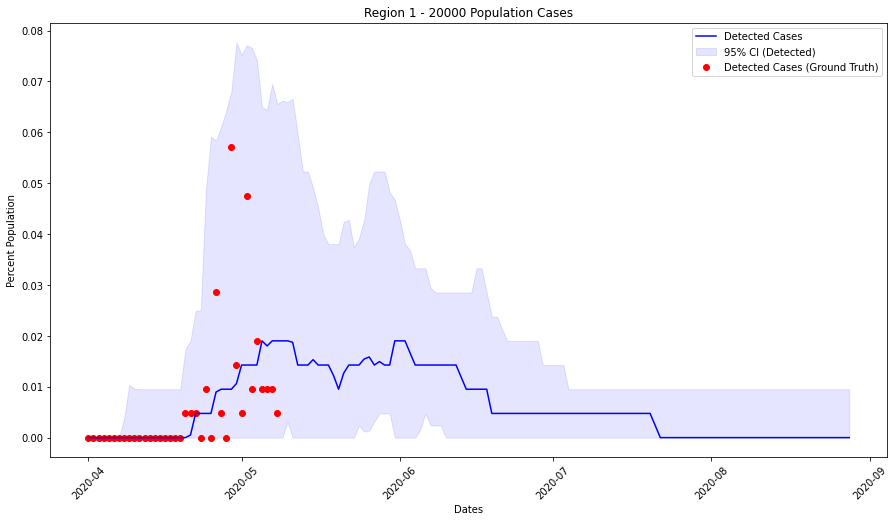

In [21]:
title = 'Region 1 - 20000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S20_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')

In [22]:
with open('region_sim2.p','rb') as fp:
    S5,S10,S20 = pickle.load(fp)

In [23]:
date_length = len(S10['timeseries'][15:])
S5_ts = np.array([float(j[1])*100.0/S5['total_pop'] for j in S5['timeseries'][15:]])-np.array([float(j[1])*100.0/S5['total_pop'] for j in S5['timeseries'][14:-1]])
S10_ts = np.array([float(j[1])*100.0/S10['total_pop'] for j in S10['timeseries'][15:]])-np.array([float(j[1])*100.0/S10['total_pop'] for j in S10['timeseries'][14:-1]])
S20_ts = np.array([float(j[1])*100.0/S20['total_pop'] for j in S20['timeseries'][15:]])-np.array([float(j[1])*100.0/S20['total_pop'] for j in S20['timeseries'][14:-1]])

I = 3
Et = [0.000, 0.0000,0.0002,0.0002]
It = [0.0001, 0.0003, 0.0009, 0.004]
sim = 1000

In [24]:
# With current testing and social distancing throughout
numNodes = S5['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, np.log(S5['total_pop']))

final = []
initI = I
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

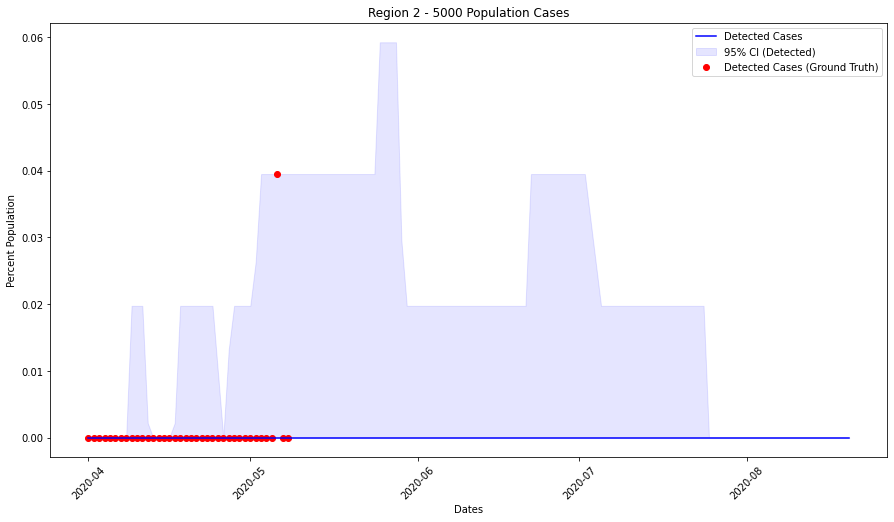

In [25]:
title = 'Region 2 - 5000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S5_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')

In [26]:
coeff = (S10['total_pop']*np.log(S10['total_pop'])*S5['area']*S5['F(S)']**2)/(S5['total_pop']*np.log(S5['total_pop'])*S10['area']*S10['F(S)']**2)

In [27]:
# With current testing and social distancing throughout
numNodes = S10['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, coeff*np.log(S5['total_pop']))

final = []
initI = int(I*coeff)
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

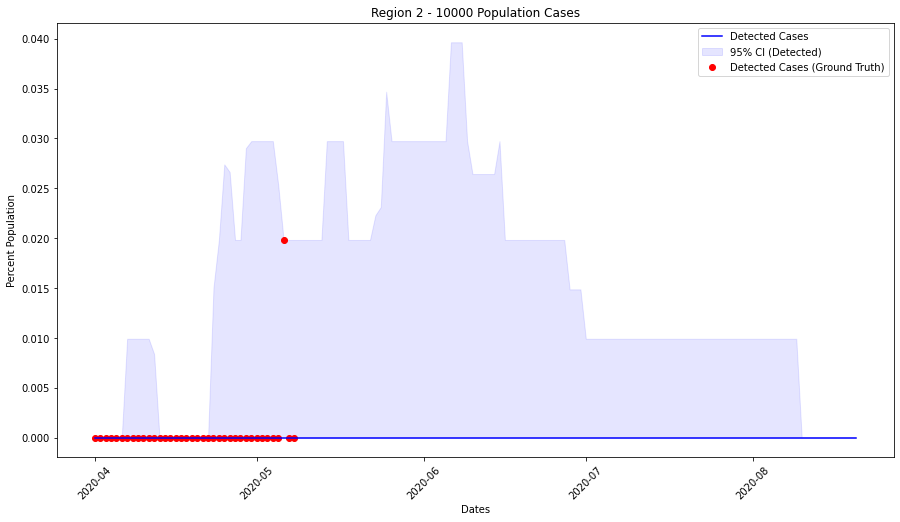

In [28]:
title = 'Region 2 - 10000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S10_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')

In [29]:
coeff = (S20['total_pop']*np.log(S20['total_pop'])*S5['area']*S5['F(S)']**2)/(S5['total_pop']*np.log(S5['total_pop'])*S20['area']*S20['F(S)']**2)

In [30]:
# With current testing and social distancing throughout
numNodes = S20['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, coeff*np.log(S5['total_pop']))


final = []
initI = int(I*coeff)
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

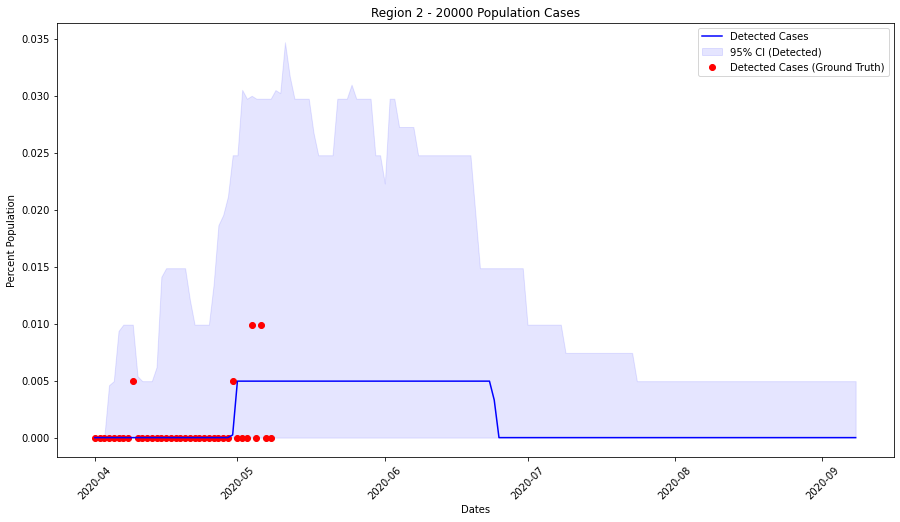

In [31]:
title = 'Region 2 - 20000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S20_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')

In [32]:
with open('region_sim3.p','rb') as fp:
    S5,S10,S20 = pickle.load(fp)

In [33]:
datedate_length = len(S10['timeseries'][15:])
S5_ts = np.array([float(j[1])*100.0/S5['total_pop'] for j in S5['timeseries'][15:]])-np.array([float(j[1])*100.0/S5['total_pop'] for j in S5['timeseries'][14:-1]])
S10_ts = np.array([float(j[1])*100.0/S10['total_pop'] for j in S10['timeseries'][15:]])-np.array([float(j[1])*100.0/S10['total_pop'] for j in S10['timeseries'][14:-1]])
S20_ts = np.array([float(j[1])*100.0/S20['total_pop'] for j in S20['timeseries'][15:]])-np.array([float(j[1])*100.0/S20['total_pop'] for j in S20['timeseries'][14:-1]])

I = 3
Et = [0.000, 0.0000,0.0002,0.0002]
It = [0.0001, 0.00054, 0.001, 0.004]
sim = 1000

In [34]:
# With current testing and social distancing throughout
numNodes = S5['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, np.log(S5['total_pop']))

final = []
initI = I
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

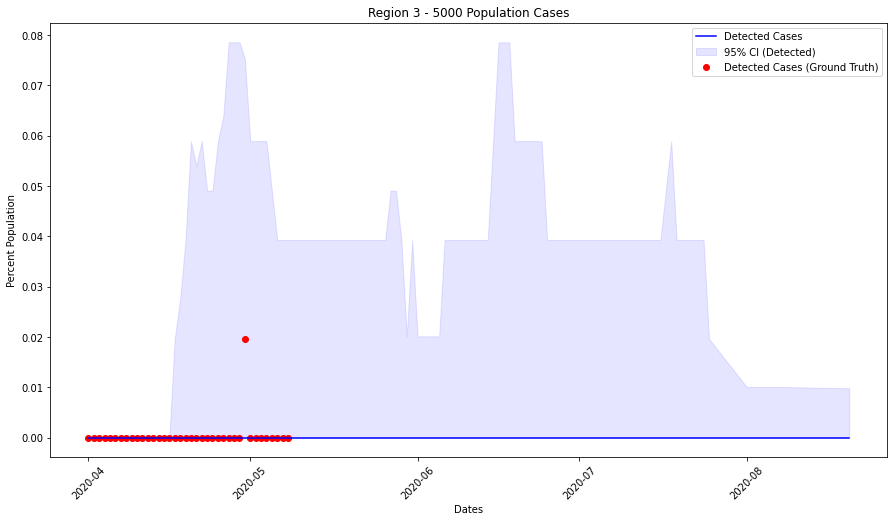

In [35]:
title = 'Region 3 - 5000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S5_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')

In [36]:
coeff = (S10['total_pop']*np.log(S10['total_pop'])*S5['area']*S5['F(S)']**2)/(S5['total_pop']*np.log(S5['total_pop'])*S10['area']*S10['F(S)']**2)

In [37]:
# With current testing and social distancing throughout
numNodes = S10['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, coeff*np.log(S5['total_pop']))

final = []
initI = int(I*coeff)
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

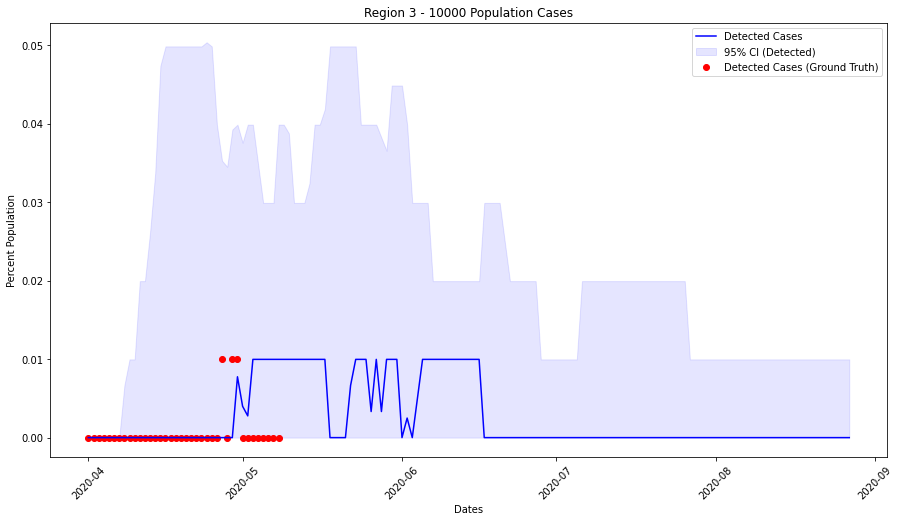

In [38]:
title = 'Region 3 - 10000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S10_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')

In [39]:
coeff = (S20['total_pop']*np.log(S20['total_pop'])*S5['area']*S5['F(S)']**2)/(S5['total_pop']*np.log(S5['total_pop'])*S20['area']*S20['F(S)']**2)

In [40]:
# With current testing and social distancing throughout
numNodes = S20['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, coeff*np.log(S5['total_pop']))


final = []
initI = int(I*coeff)
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

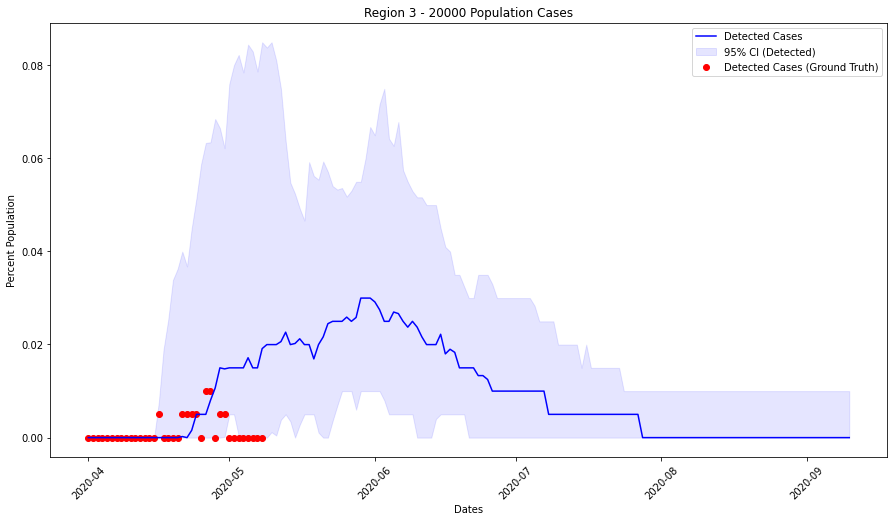

In [41]:
title = 'Region 3 - 20000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S20_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')

In [42]:
with open('region_sim4.p','rb') as fp:
    S5,S10,S20 = pickle.load(fp)

In [43]:
date_length = len(S10['timeseries'][15:])
S5_ts = np.array([float(j[1])*100.0/S5['total_pop'] for j in S5['timeseries'][15:]])-np.array([float(j[1])*100.0/S5['total_pop'] for j in S5['timeseries'][14:-1]])
S10_ts = np.array([float(j[1])*100.0/S10['total_pop'] for j in S10['timeseries'][15:]])-np.array([float(j[1])*100.0/S10['total_pop'] for j in S10['timeseries'][14:-1]])
S20_ts = np.array([float(j[1])*100.0/S20['total_pop'] for j in S20['timeseries'][15:]])-np.array([float(j[1])*100.0/S20['total_pop'] for j in S20['timeseries'][14:-1]])

I = 2
Et = [0.000, 0.0000,0.0002,0.0002]
It = [0.00002, 0.00065, 0.0013, 0.004]
sim = 1000

In [44]:
# With current testing and social distancing throughout
numNodes = S5['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, np.log(S5['total_pop']))

final = []
initI = I
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

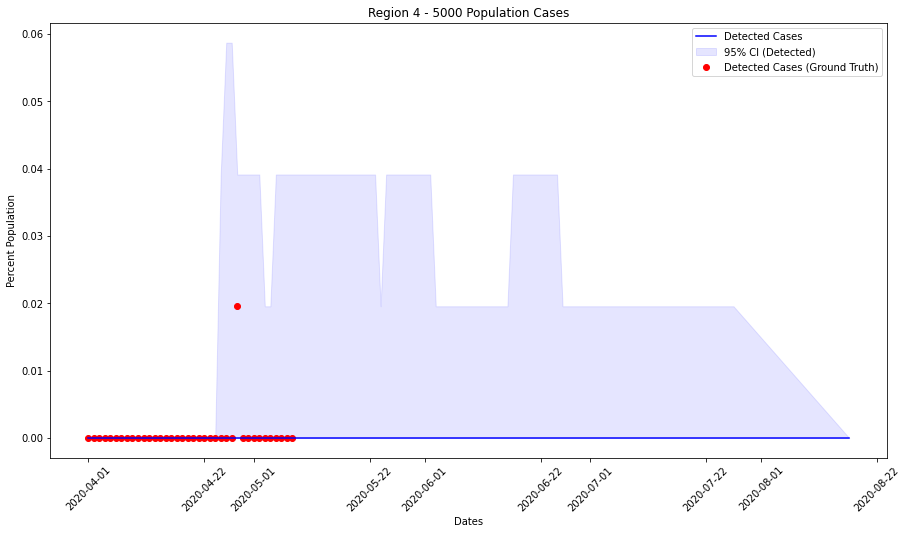

In [45]:
title = 'Region 4 - 5000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S5_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')

In [46]:
coeff = (S10['total_pop']*np.log(S10['total_pop'])*S5['area']*S5['F(S)']**2)/(S5['total_pop']*np.log(S5['total_pop'])*S10['area']*S10['F(S)']**2)

In [47]:
# With current testing and social distancing throughout
numNodes = S10['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, coeff*np.log(S5['total_pop']))

final = []
initI = int(I*coeff)
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

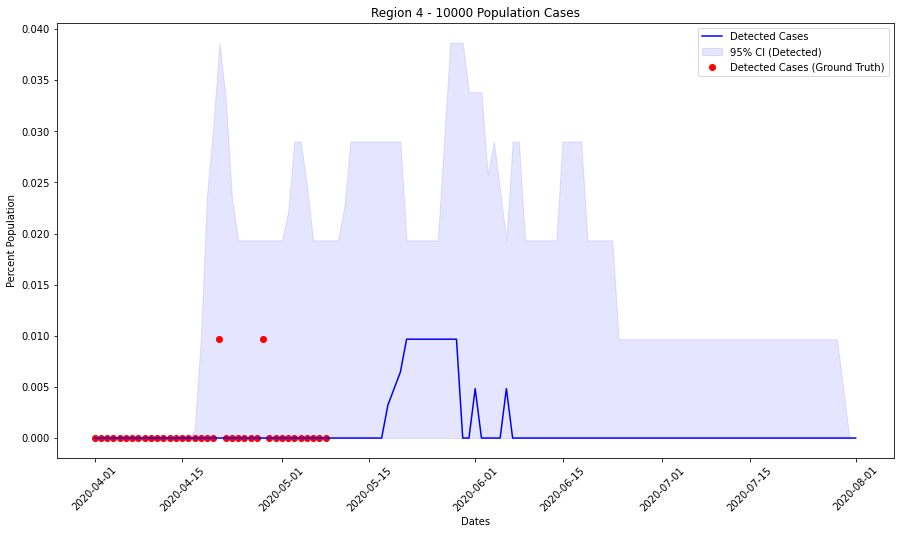

In [48]:
title = 'Region 4 - 10000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S10_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')

In [49]:
coeff = (S20['total_pop']*np.log(S20['total_pop'])*S5['area']*S5['F(S)']**2)/(S5['total_pop']*np.log(S5['total_pop'])*S20['area']*S20['F(S)']**2)

In [50]:
# With current testing and social distancing throughout
numNodes = S20['total_pop']
G_normal, G_relaxed, G_Quarantine = gen_graphs(numNodes, coeff*np.log(S5['total_pop']))


final = []
initI = int(I*coeff)
theta_E = Et[0]
theta_I = It[0]
mf = 1
checkpoints  =  {'t': [15,25,50],
                   'theta_E': Et[1:],
                   'theta_I': It[1:],
                 'G': [G_relaxed,G_Quarantine,G_Quarantine]
                      }

temp = monte(numNodes,initI=initI,theta_E = theta_E, theta_I = theta_I ,mf=mf, checkpoints=checkpoints, G = G_normal, sim=sim);

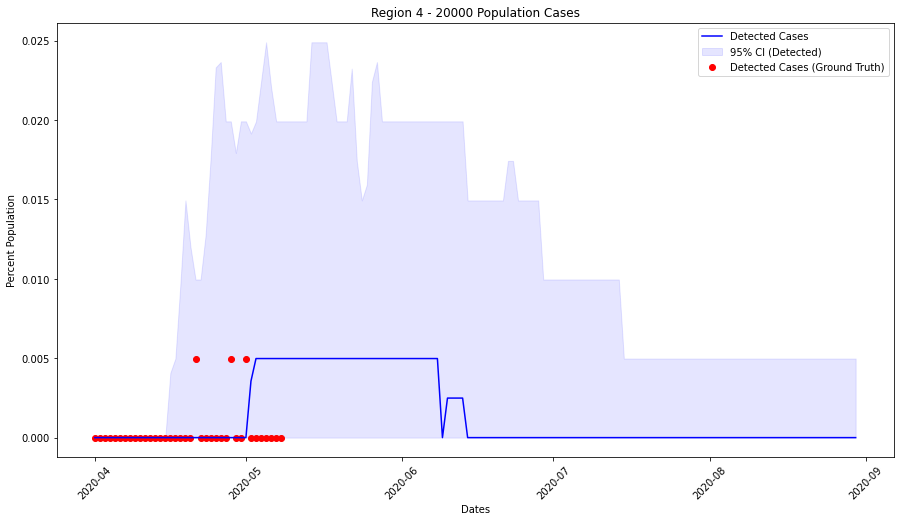

In [51]:
title = 'Region 4 - 20000 Population Cases'

plt.title(title)

dfa_DI = temp[1]
cumu = get_three_tuple(dfa_DI)

plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.ylabel('Percent Population')
plt.plot(dfa_DI.index, cumu[:,1], 'b', label='Detected Cases')
plt.fill_between(
    dfa_DI.index,
    cumu[:,0],
    cumu[:,2],
     color='b', alpha=.1, label='95% CI (Detected)'
    )
plt.scatter(
    list(dfa_DI.index)[:date_length],
    S20_ts,
    c='r', label='Detected Cases (Ground Truth)'
)

plt.legend()

plt.savefig('simu_det_plots/'+title+'.pdf')